### Visualizing weather data

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

from pyspark import SparkContext
from pyspark.sql import *
import pyspark.sql
sqlContext = SQLContext(sc)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from lib.numpy_pack import packArray,unpackArray
from spark_PCA import computeCov

In [3]:

from computeStatistics import computeOverAllDist, STAT_Descriptions

### Read weather data for state

In [5]:
state='NY'
data_dir='../Data/Weather'

tarname=state+'.tgz'
parquet=state+'.parquet'

%mkdir -p data_dir
!rm -rf $data_dir/$tarname

command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/%s > %s/%s"%(tarname,data_dir,tarname)
print(command)
!$command
!ls -lh $data_dir/$tarname

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/NY.tgz > ../Data/Weather/NY.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63.2M  100 63.2M    0     0  6403k      0  0:00:10  0:00:10 --:--:-- 8462k
-rw-r--r-- 1 jovyan users 64M May 13  2018 ../Data/Weather/NY.tgz


In [6]:
cur_dir,=!pwd
%cd $data_dir
!tar -xzf $tarname
!du ./$parquet
%cd $cur_dir


weather_df=sqlContext.read.parquet(data_dir+'/'+parquet)
print(weather_df.count())
weather_df.show(5)

/home/jovyan/work/Sections/Data/Weather
77824	./NY.parquet
/home/jovyan/work/Sections/Section2-Weather-PCA
168398
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|state|             name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1947|[79 4C 75 4C 8F 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW000947

### read statistics information for state.

In [10]:
#read statistics
filename='STAT_%s.pickle'%state
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/%s.gz > %s/%s.gz"%(filename,data_dir,filename)
print(command)
!$command

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state_2/STAT_NY.pickle.gz > ../Data/Weather/STAT_NY.pickle.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29.9M  100 29.9M    0     0  7444k      0  0:00:04  0:00:04 --:--:-- 7445k


In [9]:
gzpath='%s/%s.gz'%(data_dir,filename)
print(gzpath)
!ls -l $gzpath
!gunzip -f $gzpath
STAT,STAT_Descriptions = load(open(data_dir+'/'+filename,'rb'))
print('keys from STAT=',STAT.keys())

../Data/Weather/STAT_NY.pickle.gz
-rw-r--r-- 1 jovyan users 51365362 May 13  2018 ../Data/Weather/STAT_NY.pickle.gz

gzip: ../Data/Weather/STAT_NY.pickle.gz: not in gzip format
keys from STAT= dict_keys(['SNOW_s20', 'TMIN_s20', 'TOBS', 'SNWD_s20', 'PRCP_s20', 'TOBS_s20', 'PRCP', 'TMAX', 'TMAX_s20', 'TMIN', 'SNOW', 'SNWD'])


### Read information about US weather stations.

In [97]:
filename='US_stations.tsv.gz'
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/Info/%s > %s/%s"%(filename,data_dir,filename)
print(command)
!$command
filename_no_gz = filename[:-3]
!gunzip -f $data_dir/$filename
!ls -lh $data_dir/US_stations*

curl https://mas-dse-open.s3.amazonaws.com/Weather/Info/US_stations.tsv.gz > ../../Data/Weather/US_stations.tsv.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  320k  100  320k    0     0   320k      0  0:00:01 --:--:--  0:00:01  455k
-rw-r--r--  1 yoavfreund  staff   714K Mar 25 15:57 ../../Data/Weather/US_stations.tsv


In [98]:
#read csv into pandas dataframe
PATH='%s/%s'%(data_dir,filename_no_gz)
print(PATH)
stations=pd.read_csv(PATH,sep='\t')

../../Data/Weather/US_stations.tsv


In [99]:
from pyspark.sql.types import Row, StructField, StructType, StringType, IntegerType, FloatType,BinaryType

schema = StructType([StructField("Station", StringType(), False),
                     StructField("Dist_coast", FloatType(), False),
                     StructField("Latitude", FloatType(), False),
                     StructField("Longitude", FloatType(), False),
                     StructField("Elevation", FloatType(), False),
                     StructField("State", StringType(), True),                  
                     StructField("Name", StringType(), False)])                


In [101]:
stations_df = sqlContext.createDataFrame(stations,schema).drop('State')
stations_df.show(4)

+-----------+----------+--------+---------+---------+----------------+
|    Station|Dist_coast|Latitude|Longitude|Elevation|            Name|
+-----------+----------+--------+---------+---------+----------------+
|USC00044534|   107.655| 36.0042|  -119.96|     73.2|  KETTLEMAN CITY|
|USC00356784|   0.61097| 42.7519|-124.5011|     12.8|PORT ORFORD NO 2|
|USC00243581|   1316.54| 47.1064|-104.7183|    632.8|        GLENDIVE|
|USC00205601|   685.501|   41.75| -84.2167|    247.2|         MORENCI|
+-----------+----------+--------+---------+---------+----------------+
only showing top 4 rows



In [102]:
jdf=weather_df.join(stations_df,on='Station',how='left')
jdf.show(4)

+-----------+-----------+----+--------------------+-----+----------+--------+---------+---------+-------+
|    Station|Measurement|Year|              Values|State|Dist_coast|Latitude|Longitude|Elevation|   Name|
+-----------+-----------+----+--------------------+-----+----------+--------+---------+---------+-------+
|USC00303955|       PRCP|1992|[00 7E 00 7E 00 7...|   NY|   362.277| 42.7919| -77.5136|    243.8|HONEOYE|
|USC00303955|       PRCP|1993|[00 00 00 00 00 0...|   NY|   362.277| 42.7919| -77.5136|    243.8|HONEOYE|
|USC00303955|       PRCP|1994|[00 00 00 00 00 0...|   NY|   362.277| 42.7919| -77.5136|    243.8|HONEOYE|
|USC00303955|       PRCP|1995|[00 4F 00 49 80 4...|   NY|   362.277| 42.7919| -77.5136|    243.8|HONEOYE|
+-----------+-----------+----+--------------------+-----+----------+--------+---------+---------+-------+
only showing top 4 rows



In [103]:
jdf.select(['Station','Measurement','Year','Name']).show(4)

+-----------+-----------+----+-------+
|    Station|Measurement|Year|   Name|
+-----------+-----------+----+-------+
|USC00303955|       PRCP|1992|HONEOYE|
|USC00303955|       PRCP|1993|HONEOYE|
|USC00303955|       PRCP|1994|HONEOYE|
|USC00303955|       PRCP|1995|HONEOYE|
+-----------+-----------+----+-------+
only showing top 4 rows



In [104]:
jdf.count()

84199

In [105]:
sqlContext.registerDataFrameAsTable(jdf,'jdf')

In [106]:
# get all measurements for a particular year and a particular station
measurement='PRCP'
Query="""
SELECT *
FROM jdf 
WHERE Measurement='%s'
AND Name='BUFFALO'
ORDER BY YEAR"""%(measurement)
df=sqlContext.sql(Query)
print(df.count())
df.show(3)

150
+-----------+-----------+----+--------------------+-----+----------+--------+---------+---------+-------+
|    Station|Measurement|Year|              Values|State|Dist_coast|Latitude|Longitude|Elevation|   Name|
+-----------+-----------+----+--------------------+-----+----------+--------+---------+---------+-------+
|USC00301010|       PRCP|1871|[00 42 00 00 00 4...|   NY|   437.752| 42.8833| -78.8833|   -999.9|BUFFALO|
|USC00301010|       PRCP|1872|[40 4E 00 00 60 5...|   NY|   437.752| 42.8833| -78.8833|   -999.9|BUFFALO|
|USC00301010|       PRCP|1873|[00 00 40 4E 00 4...|   NY|   437.752| 42.8833| -78.8833|   -999.9|BUFFALO|
+-----------+-----------+----+--------------------+-----+----------+--------+---------+---------+-------+
only showing top 3 rows



In [107]:
df.select(['Station','Year','Values']).schema

StructType(List(StructField(Station,StringType,true),StructField(Year,IntegerType,true),StructField(Values,BinaryType,true)))

### Smoothing by convolving with gaussian window

In [108]:
from astropy.convolution import convolve
from scipy import signal
#using astrophy.convolution.convolve and not scipy.signal.convolve because the first can handle nans.

orig_pdf=df.toPandas()
orig_pdf.head()

def Smoother(orig_pdf,order=101,std=20):
    window = signal.gaussian(order, std=std)
    window/=sum(window)

    L=list(orig_pdf['Values'])

    orig=np.stack([unpackArray(V,np.float16) for V in L])
    orig_shape=orig.shape
    orig=orig.flatten()

    smoothed = convolve(orig, window)
    smoothed=np.reshape(smoothed,orig_shape)

    #create a new pandas dataframe
    smoothed_pdf=orig_pdf.copy()   # make a copy

    L=[packArray(smoothed[i,:]) for i in range(smoothed.shape[0])]
    smoothed_pdf['Values']=L

    smoothed_pdf.loc[0,'Measurement']

    new_name = 'smooth_'+smoothed_pdf.loc[0,'Measurement']
    smoothed_pdf['Measurement']=new_name
    return smoothed_pdf

In [109]:
smoothed_pdf=Smoother(orig_pdf)
smoothed_pdf.head(3)

,Station,Measurement,Year,Values,State,Dist_coast,Latitude,Longitude,Elevation,Name
0,USC00301010,smooth_PRCP,1871,"[150, 68, 209, 68, 13, 69, 73, 69, 135, 69, 19...",NY,437.752014,42.883301,-78.883301,-999.900024,BUFFALO
1,USC00301010,smooth_PRCP,1872,"[199, 76, 201, 76, 204, 76, 183, 76, 182, 76, ...",NY,437.752014,42.883301,-78.883301,-999.900024,BUFFALO
2,USC00301010,smooth_PRCP,1873,"[222, 75, 207, 75, 194, 75, 180, 75, 150, 75, ...",NY,437.752014,42.883301,-78.883301,-999.900024,BUFFALO


In [110]:
Query="""
SELECT Station,count(Year) as count
FROM jdf 
WHERE Measurement='%s'
GROUP BY Station
ORDER BY count
"""%(measurement)
stat_pdf=sqlContext.sql(Query).toPandas()
stat_pdf.tail(4)

,Station,count
339,USC00306774,121
340,USC00304912,123
341,USC00307633,125
342,USW00094728,138


In [111]:
stations=list(stat_pdf['Station'])
stations=stations[-1:0:-1]
stations[:4]

['USW00094728', 'USC00307633', 'USC00304912', 'USC00306774']

In [112]:
import pyspark.sql.functions as sqlf
import pyspark
import pyarrow
pyspark.__version__

'2.3.0'

In [113]:
ndf=Smoother(orig_pdf)
ndf.head(3)

,Station,Measurement,Year,Values,State,Dist_coast,Latitude,Longitude,Elevation,Name
0,USC00301010,smooth_PRCP,1871,"[150, 68, 209, 68, 13, 69, 73, 69, 135, 69, 19...",NY,437.752014,42.883301,-78.883301,-999.900024,BUFFALO
1,USC00301010,smooth_PRCP,1872,"[199, 76, 201, 76, 204, 76, 183, 76, 182, 76, ...",NY,437.752014,42.883301,-78.883301,-999.900024,BUFFALO
2,USC00301010,smooth_PRCP,1873,"[222, 75, 207, 75, 194, 75, 180, 75, 150, 75, ...",NY,437.752014,42.883301,-78.883301,-999.900024,BUFFALO


In [126]:
from time import time
# get all measurements for a particular year and a particular station
measurement='PRCP'
Query_template="""
SELECT *
FROM jdf 
WHERE Measurement='%s'
AND Station='%s'
ORDER BY YEAR"""

for station in stations:
    t0=time()
    Query=Query_template%(measurement,station)

    pdf=sqlContext.sql(Query).toPandas()
    t1=time()
    smoothed_pdf=Smoother(pdf)
    t2=time()
    smoothed_df= sqlContext.createDataFrame(smoothed_pdf)
    jdf=jdf.union(smoothed_df)
    t3=time()
    print('Station=%s, rows=%d, prep=%5.2f,compute=%5.2f,cleanup=%f5.2,total=%f5.2'
          %(station,pdf.shape[0],t1-t0,t2-t1,t3-t2,t3-t0))

Station=USW00094728, rows=138, prep= 2.38,compute= 0.02,cleanup=0.0312015.2,total=2.4221745.2
Station=USC00307633, rows=125, prep= 2.08,compute= 0.01,cleanup=0.0274295.2,total=2.1190015.2
Station=USC00304912, rows=123, prep= 2.59,compute= 0.01,cleanup=0.0283535.2,total=2.6333555.2
Station=USC00306774, rows=121, prep= 2.34,compute= 0.01,cleanup=0.0286915.2,total=2.3848445.2
Station=USC00304174, rows=121, prep= 2.29,compute= 0.01,cleanup=0.0270555.2,total=2.3320715.2
Station=USC00301752, rows=121, prep= 2.21,compute= 0.01,cleanup=0.0295485.2,total=2.2483565.2
Station=USC00302610, rows=121, prep= 2.12,compute= 0.01,cleanup=0.0285305.2,total=2.1566885.2
Station=USC00306164, rows=121, prep= 1.97,compute= 0.01,cleanup=0.0282435.2,total=2.0129405.2
Station=USC00309000, rows=120, prep= 2.33,compute= 0.01,cleanup=0.0273515.2,total=2.3735085.2
Station=USC00300183, rows=120, prep= 2.05,compute= 0.01,cleanup=0.0291565.2,total=2.0866155.2
Station=USC00309292, rows=118, prep= 2.00,compute= 0.02,clea

Station=USC00301152, rows=72, prep= 1.88,compute= 0.01,cleanup=0.0295655.2,total=1.9189345.2
Station=USC00303889, rows=72, prep= 1.83,compute= 0.01,cleanup=0.0280805.2,total=1.8644865.2
Station=USC00300766, rows=71, prep= 2.70,compute= 0.01,cleanup=0.0302265.2,total=2.7432365.2
Station=USC00306623, rows=70, prep= 2.05,compute= 0.01,cleanup=0.0297575.2,total=2.0915735.2
Station=USW00014750, rows=70, prep= 1.90,compute= 0.01,cleanup=0.0272255.2,total=1.9398105.2
Station=USW00014732, rows=70, prep= 1.86,compute= 0.01,cleanup=0.0272125.2,total=1.8946415.2
Station=USC00302574, rows=70, prep= 1.81,compute= 0.01,cleanup=0.0298805.2,total=1.8521575.2
Station=USC00303284, rows=70, prep= 1.84,compute= 0.01,cleanup=0.0280215.2,total=1.8736795.2
Station=USC00302129, rows=68, prep= 1.88,compute= 0.01,cleanup=0.0297875.2,total=1.9165035.2
Station=USW00094745, rows=68, prep= 1.91,compute= 0.01,cleanup=0.0295395.2,total=1.9450845.2
Station=USC00300047, rows=68, prep= 1.98,compute= 0.01,cleanup=0.02785

Station=USC00304715, rows=38, prep= 1.71,compute= 0.00,cleanup=0.0278235.2,total=1.7411775.2
Station=USC00305711, rows=38, prep= 2.24,compute= 0.00,cleanup=0.0319935.2,total=2.2755565.2
Station=USC00308902, rows=38, prep= 1.73,compute= 0.00,cleanup=0.0285505.2,total=1.7598875.2
Station=USC00308746, rows=37, prep= 1.98,compute= 0.00,cleanup=0.0292355.2,total=2.0156405.2
Station=USC00308152, rows=37, prep= 2.15,compute= 0.00,cleanup=0.0314895.2,total=2.1834135.2
Station=USC00308080, rows=37, prep= 1.73,compute= 0.00,cleanup=0.0315205.2,total=1.7645085.2
Station=USC00308946, rows=36, prep= 1.68,compute= 0.00,cleanup=0.0286955.2,total=1.7094405.2
Station=USC00306957, rows=36, prep= 1.69,compute= 0.00,cleanup=0.0319025.2,total=1.7307925.2
Station=USC00306356, rows=35, prep= 1.83,compute= 0.00,cleanup=0.0293085.2,total=1.8625045.2
Station=USC00301095, rows=35, prep= 1.67,compute= 0.00,cleanup=0.0300805.2,total=1.7061075.2
Station=USW00014748, rows=35, prep= 1.69,compute= 0.00,cleanup=0.02850

Station=USC00309442, rows=14, prep= 2.50,compute= 0.00,cleanup=0.0337715.2,total=2.5412095.2
Station=USC00302047, rows=14, prep= 1.91,compute= 0.00,cleanup=0.0385035.2,total=1.9532205.2
Station=USC00304530, rows=13, prep= 1.83,compute= 0.00,cleanup=0.0367265.2,total=1.8648075.2
Station=USC00306232, rows=13, prep= 1.73,compute= 0.00,cleanup=0.0337835.2,total=1.7638235.2
Station=USC00301272, rows=13, prep= 1.70,compute= 0.00,cleanup=0.0309245.2,total=1.7346735.2
Station=USC00308386, rows=13, prep= 1.70,compute= 0.00,cleanup=0.0311215.2,total=1.7327045.2
Station=USC00304208, rows=13, prep= 1.71,compute= 0.00,cleanup=0.0329325.2,total=1.7434205.2
Station=USC00308773, rows=13, prep= 1.69,compute= 0.00,cleanup=0.0332575.2,total=1.7282235.2
Station=USC00305346, rows=13, prep= 1.62,compute= 0.00,cleanup=0.0317085.2,total=1.6545755.2
Station=USC00305816, rows=13, prep= 1.72,compute= 0.00,cleanup=0.0321945.2,total=1.7516955.2
Station=USC00300424, rows=12, prep= 1.74,compute= 0.00,cleanup=0.03690

In [127]:
jdf.count()

100453

In [128]:
!ls ../../Data/Weather/

1.FunctionsAsVectors_CLASS.ipynb
1.FunctionsAsVectors_MASTER.ipynb
2.PCA_computation per state.ipynb
2.Small_PCA_computation_CLASS.ipynb
2.Small_PCA_compute_all.ipynb
4.0 Weather Analysis - Initial Visualisation.ipynb
4.4 Weather Analysis - Visualisation.ipynb
4.5 Weather Analysis - reconstruction SNWD.ipynb
5. maps using iPyLeaflet.ipynb
5.5 DataOnMaps.ipynb
6. Is SNWD variation spatial or temporal?.ipynb
7. Analyzing residuals-Cov.ipynb
7. Analyzing residuals.ipynb
Figures
HW5.README.txt
Prelim. Weather Analysis - Smoothing..ipynb
__init__.py
data_preparation
lib
old
percipitation.png
r_figures
spark-warehouse


In [129]:
outfilename='../../Data/Weather/Joined_smoothed_PRCP.parquet'
jdf.write.save(outfilename)

In [131]:
!du -sh $outfilename

 52M	../../Data/Weather/Joined_smoothed_PRCP.parquet


In [118]:
print(pdf.columns)
sdf = sqlContext.createDataFrame(pdf)
sdf.schema

Index(['Station', 'Measurement', 'Year', 'Values', 'State', 'Dist_coast',
       'Latitude', 'Longitude', 'Elevation', 'Name'],
      dtype='object')


StructType(List(StructField(Station,StringType,true),StructField(Measurement,StringType,true),StructField(Year,LongType,true),StructField(Values,BinaryType,true),StructField(State,StringType,true),StructField(Dist_coast,DoubleType,true),StructField(Latitude,DoubleType,true),StructField(Longitude,DoubleType,true),StructField(Elevation,DoubleType,true),StructField(Name,StringType,true)))

In [119]:
# 'smoothed_%s'%(station),
sdf.count()

138

In [122]:
jdf.count()

84199

In [123]:
jdf=jdf.union(sdf)
jdf.count()

84337

## BinaryType not supported  by pandas_udf
Running the following code: 
```python
import pyspark.sql.functions as sqlf
import pyspark
import pyarrow
pyspark.__version__  (2.3.0)

from pyspark.sql.functions import pandas_udf, PandasUDFType
def Smoother(orig_pdf):
    return orig_pdf

### Offending command
smoother_udf=pandas_udf(Smoother,df.select(['Station','Year','Values']).schema, PandasUDFType.GROUPED_MAP) 

X=df.groupby("Station").apply(smoother_udf)
X.show()
```
Generates the following error message
```
NotImplementedError: Invalid returnType with grouped map Pandas UDFs: StructType(List(StructField(Station,StringType,true),StructField(Year,IntegerType,true),StructField(Values,BinaryType,true))) is not supported
```

Works find if only ('Station','Year') are used

In [45]:
orig_df.schema

StructType(List(StructField(Station,StringType,true),StructField(Measurement,StringType,true),StructField(Year,IntegerType,true),StructField(Values,BinaryType,true),StructField(State,StringType,true),StructField(Dist_coast,FloatType,true),StructField(Latitude,FloatType,true),StructField(Longitude,FloatType,true),StructField(Elevation,FloatType,true),StructField(State,StringType,true),StructField(Name,StringType,true)))

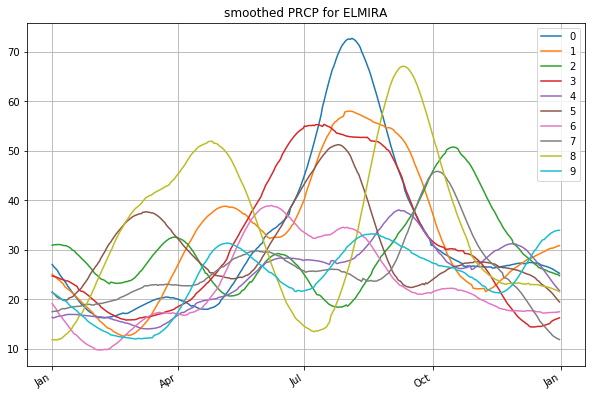

In [33]:
from lib.YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(smoothed[110:120,:].transpose(),fig,ax,title='smoothed %s for %s'%(measurement,stat));
plt.savefig('percipitation.png')
#title('A sample of graphs');

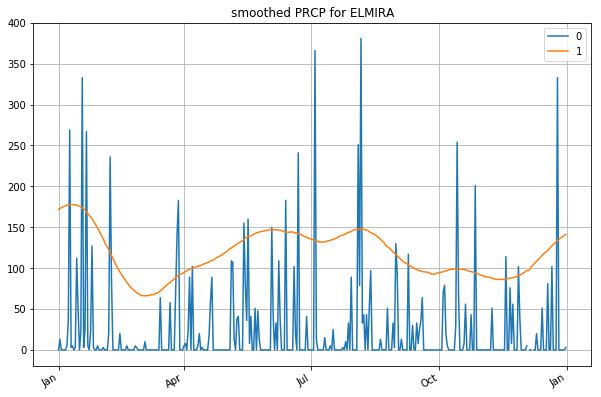

In [139]:
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
i=85
factor=5
pair=np.stack([orig[i,:],smoothed[i,:]*factor])
pair.shape

YP.plot(pair.transpose(),fig,ax,title='smoothed %s for %s'%(measurement,stat));

In [67]:
from scipy import signal
from astropy.convolution import convolve
window = signal.gaussian(81, std=20)

window/=sum(window)

365


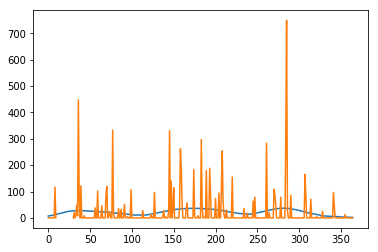

In [70]:
P=T[3,:]
P[10:30]=np.nan
f=filtered = convolve(P, window)
print(len(f))
plot(f)
plot(P)

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [21]:
from MultiPlot import *                
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

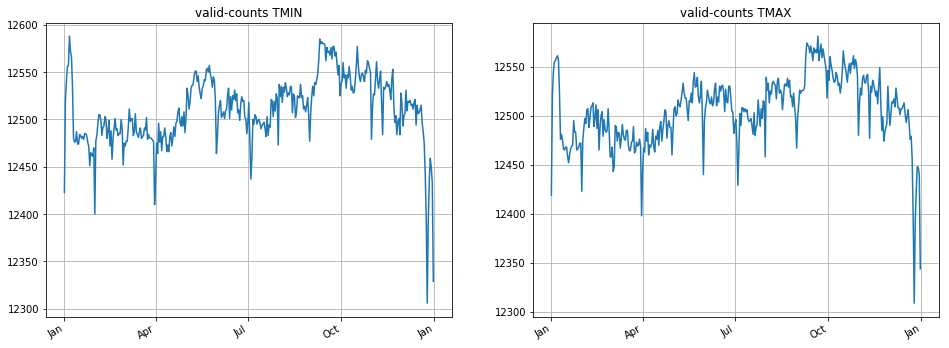

In [22]:
plot_pair(['TMIN','TMAX'],plot_valid)

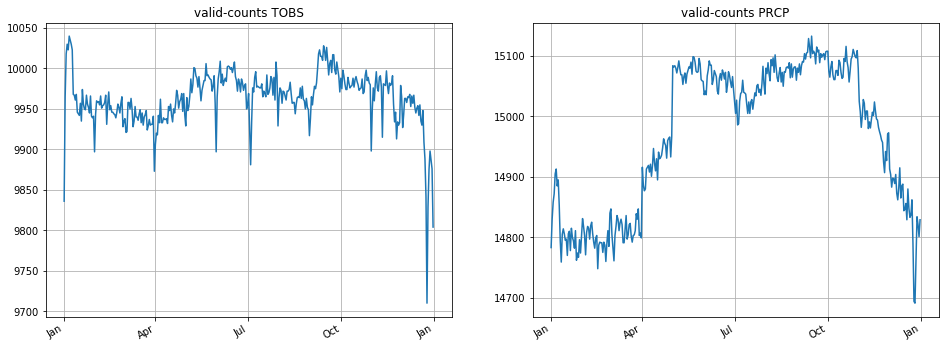

In [23]:
plot_pair(['TOBS','PRCP'],plot_valid)

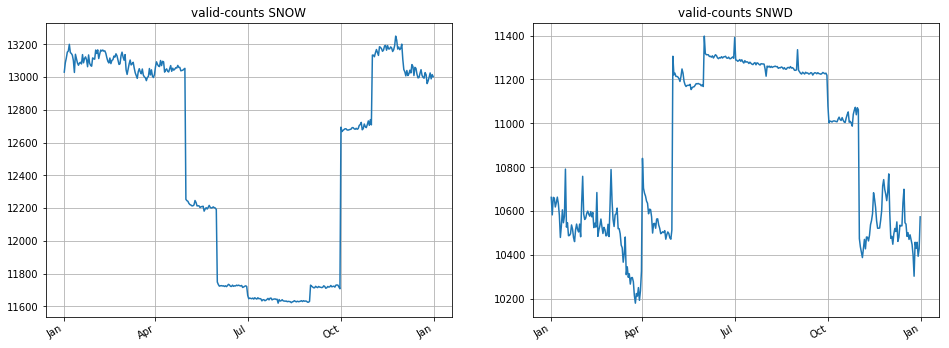

In [24]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [25]:
def plot_mean_std(m,fig,axis):
    scale=1.
    temps=['TMIN','TMAX','TOBS']
    percipitation=['PRCP','SNOW','SNWD']
    _labels=['mean+std','mean','mean-std']
    if (m in temps or m=='PRCP'):
        scale=10.
    mean=STAT[m]['Mean']/scale
    std=np.sqrt(STAT[m]['Var'])/scale
    graphs=np.vstack([mean+std,mean,mean-std]).transpose()
    YP.plot(graphs,fig,axis,labels=_labels,title='Mean+-std   '+m)
    if (m in temps):
        axis.set_ylabel('Degrees Celsius')
    if (m in percipitation):
        axis.set_ylabel('millimeter')



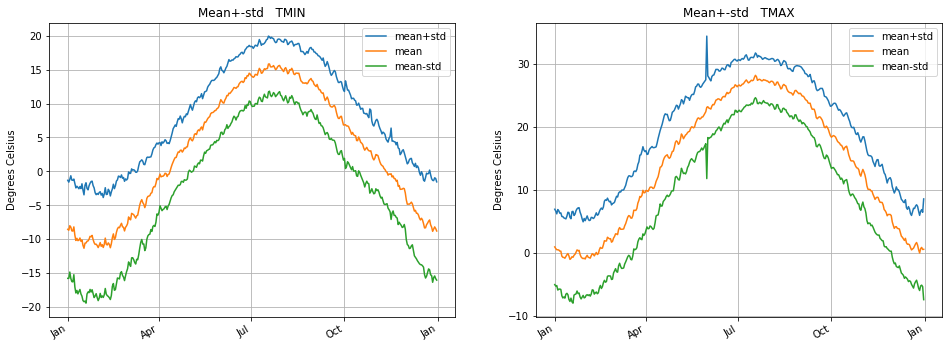

In [26]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

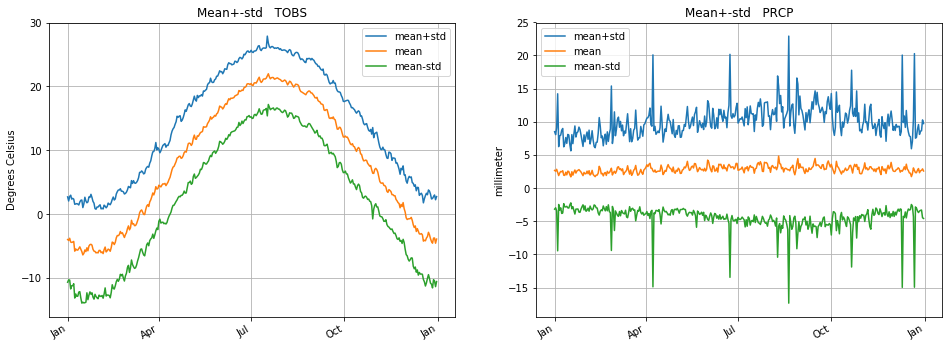

In [27]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

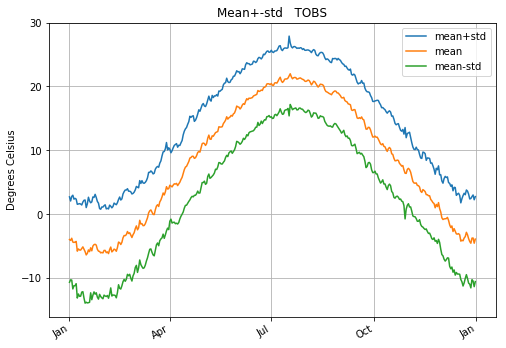

In [28]:
plot_single('TOBS',plot_mean_std,'r_figures/TOBS.png')

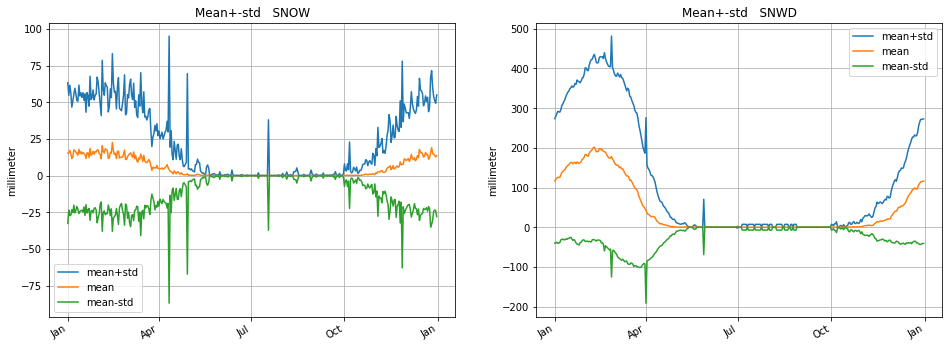

In [29]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

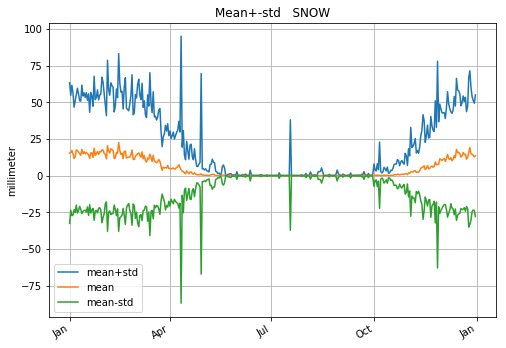

In [30]:
plot_single('SNOW',plot_mean_std,'r_figures/SNOW.png')

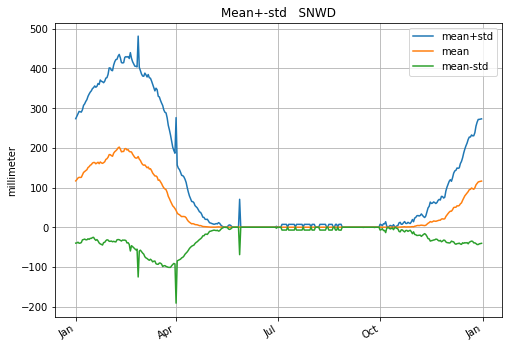

In [31]:
plot_single('SNWD',plot_mean_std,'r_figures/SNWD.png')

### plotting top 3 eigenvectors

In [32]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

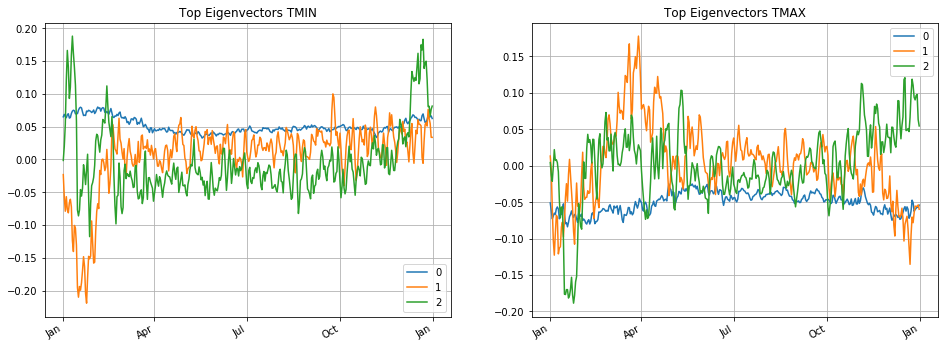

In [33]:
plot_pair(['TMIN','TMAX'],plot_eigen)

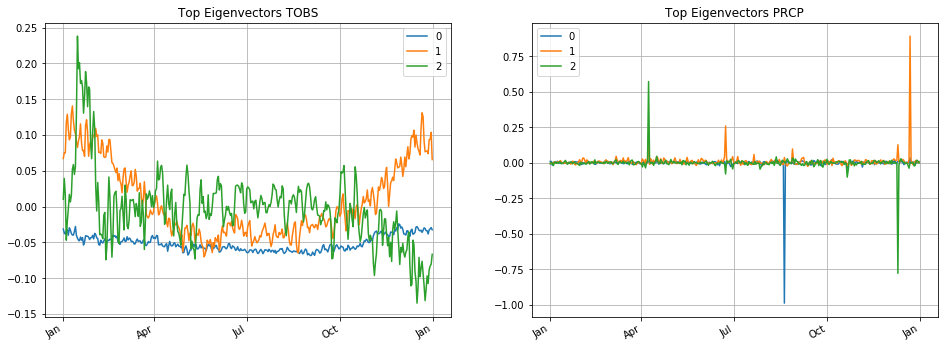

In [34]:
plot_pair(['TOBS','PRCP'],plot_eigen)

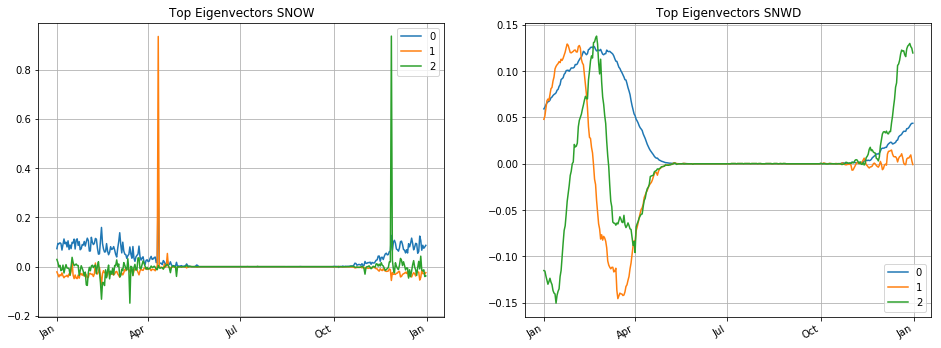

In [35]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [36]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    L=([0,]+list(cumsum(EV[:k])))/sum(EV)
    #print m,L
    plot(L)
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

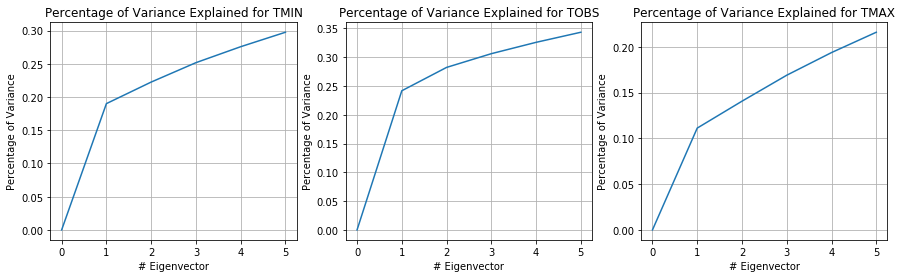

In [37]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1
f.savefig('r_figures/VarExplained1.png')

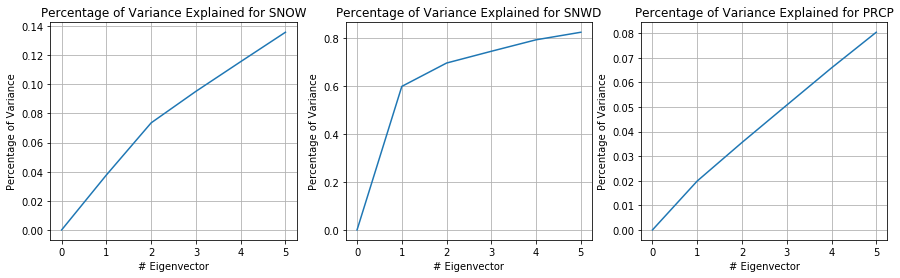

In [38]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 
f.savefig('r_figures/VarExplained2.png')

In [39]:
#sc.stop()